# Clusterning

## Based on the article [PATS](http://ismir2002.ircam.fr/proceedings/OKPROC02-FP07-4.pdf)

The ideia is to establish a similarity metric and do a clusterization process with this metrics. 

In [162]:
import pandas as pd 
import numpy as np 
from sklearn.cluster import AffinityPropagation, SpectralClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from seaborn import heatmap 
import matplotlib.pyplot as plt

In [101]:
tracks = pd.read_pickle('../data/sp_tracks_ready_469.pkl')
playlists = pd.read_pickle('../data/sp_playlists.pkl')
audio_features = pd.read_pickle('../data/sp_audio_features.pkl')

tracks.drop_duplicates('id', inplace = True)
tracks = tracks.merge(audio_features, on = 'id')

In [102]:
tracks['album_release_date'] = tracks['album_release_date'].apply(pd.to_datetime)
tracks['years'] = tracks['album_release_date'].apply(lambda x: x.year + x.month/12 + x.day/365)
tracks.set_index('id', inplace = True)

In [114]:
features_categorical =  ['explicit', 'album_type', 'album_id', 'key', 'mode', 'time_signature']
features_numerical = ['duration_ms_x', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo','years']
features_set_oriented = ['artists_ids']

features = [] 
features.extend(features_categorical)
features.extend(features_numerical)
features.extend(features_set_oriented)

In [123]:
metric_categorical = lambda x1,x2: 1*(x1 == x2)
metric_set_oriented = lambda x1, x2: len(set(x1).intersection(set(x2)))/(max(len(x1), len(x2)))
metric_numerical = lambda x1, x2, span: 1 - abs(x1 - x2)/span

span = [tracks[feat].max() - tracks[feat].min() for feat in features_numerical]

weight = [1/50]*6 + [(1 - 6/50)/13]*13

def metric_songs(x, y): 
    # x, y arrays
    similarity = 0
    for i in range(6):
        similarity += weight[i]*metric_categorical(x[i], y[i])
    for i in range(6,18):
        similarity += weight[i]*metric_numerical(x[i], y[i], span[i-6])
    similarity += weight[18]*metric_set_oriented(x[18], y[18])

    return similarity

## Simple example

In [121]:
x1 = np.array(tracks[features].iloc[0])
x2 = np.array(tracks[features].iloc[50])
metric_songs(x1, x2)

0.6909966618504537

In [148]:
tracks_array = tracks[features].values

In [150]:
def pairwise_similarity(track_array): 
    
    n = len(track_array)
    tracks_similarity = np.empty((n,n))

    for i in range(n):
        for j in range(i, n):
            m = metric_songs(track_array[i], track_array[j])
            tracks_similarity[i,j] = m
            tracks_similarity[j,i] = m
    
    return tracks_similarity

In [173]:
tracks_similarity = pairwise_similarity(tracks_array[0:1000])

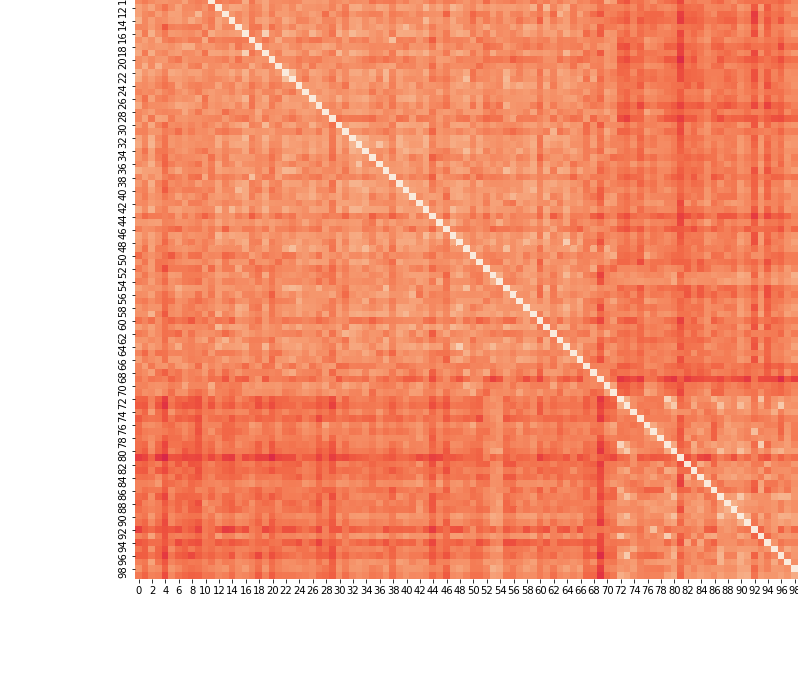

In [164]:
fig, ax = plt.subplots(figsize = (15,12))
heatmap(tracks_similarity, vmin = 0, vmax = 1, ax = ax)

plt.show()

In [174]:
model = AffinityPropagation().fit(tracks_similarity)

Quantos labels foram feitos? 

In [183]:
max(model.labels_) + 1

57

Quantas playlists realmente existiam?

In [184]:
len(tracks.iloc[0:1000].playlist_id.unique())

17

In [196]:
model2 = DBSCAN(eps = 0.7).fit(tracks_similarity)

In [197]:
set(model2.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [201]:
len(model2.labels_[model2.labels_ == -1])

460

In [203]:
model3 = SpectralClustering(n_clusters=17).fit(tracks_similarity)